A very didactic version of this example, entitled MCMC Sampling for Dummies," can be found at [Thomas Wiecki's site](https://twiecki.io/). Any reader who is completely new to MCMC, will benefit from studying this presentation that concretely shows the MCMC in action, step-by-step. 


## Setting up the problem

Recall that we want to use  a Markov chain to perform an improved Monte Carlo simulation. We can do this thanks to the aforementioned theorems that prove the convergence of the generated chain,  under conditions
of ergodicity and reversibility, to a stationary distribution. By design,
this stationary distribution is the posterior distribution that we are
trying to sample. The secret is that the MCMC performs better
exploitation of zones with higher likelihood. This is achieved by using
a proposal distribution \(q\) together with an acceptance ratio \(r\)
that together ensure that the chain explores regions of higher posterior
probability more frequently than zones of lower posterior probability.

First, we import the necessary modules.

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white') # no gridlines
sns.set_context('talk')# thicker lines

np.random.seed(123)

To generate the data, we sample $20$ points from a normal distribution, centered at zero. Our goal will be to estimate the posterior of the mean
`mu` assuming that we know the standard deviation, equal to one.

In [2]:
data = np.random.randn(20)

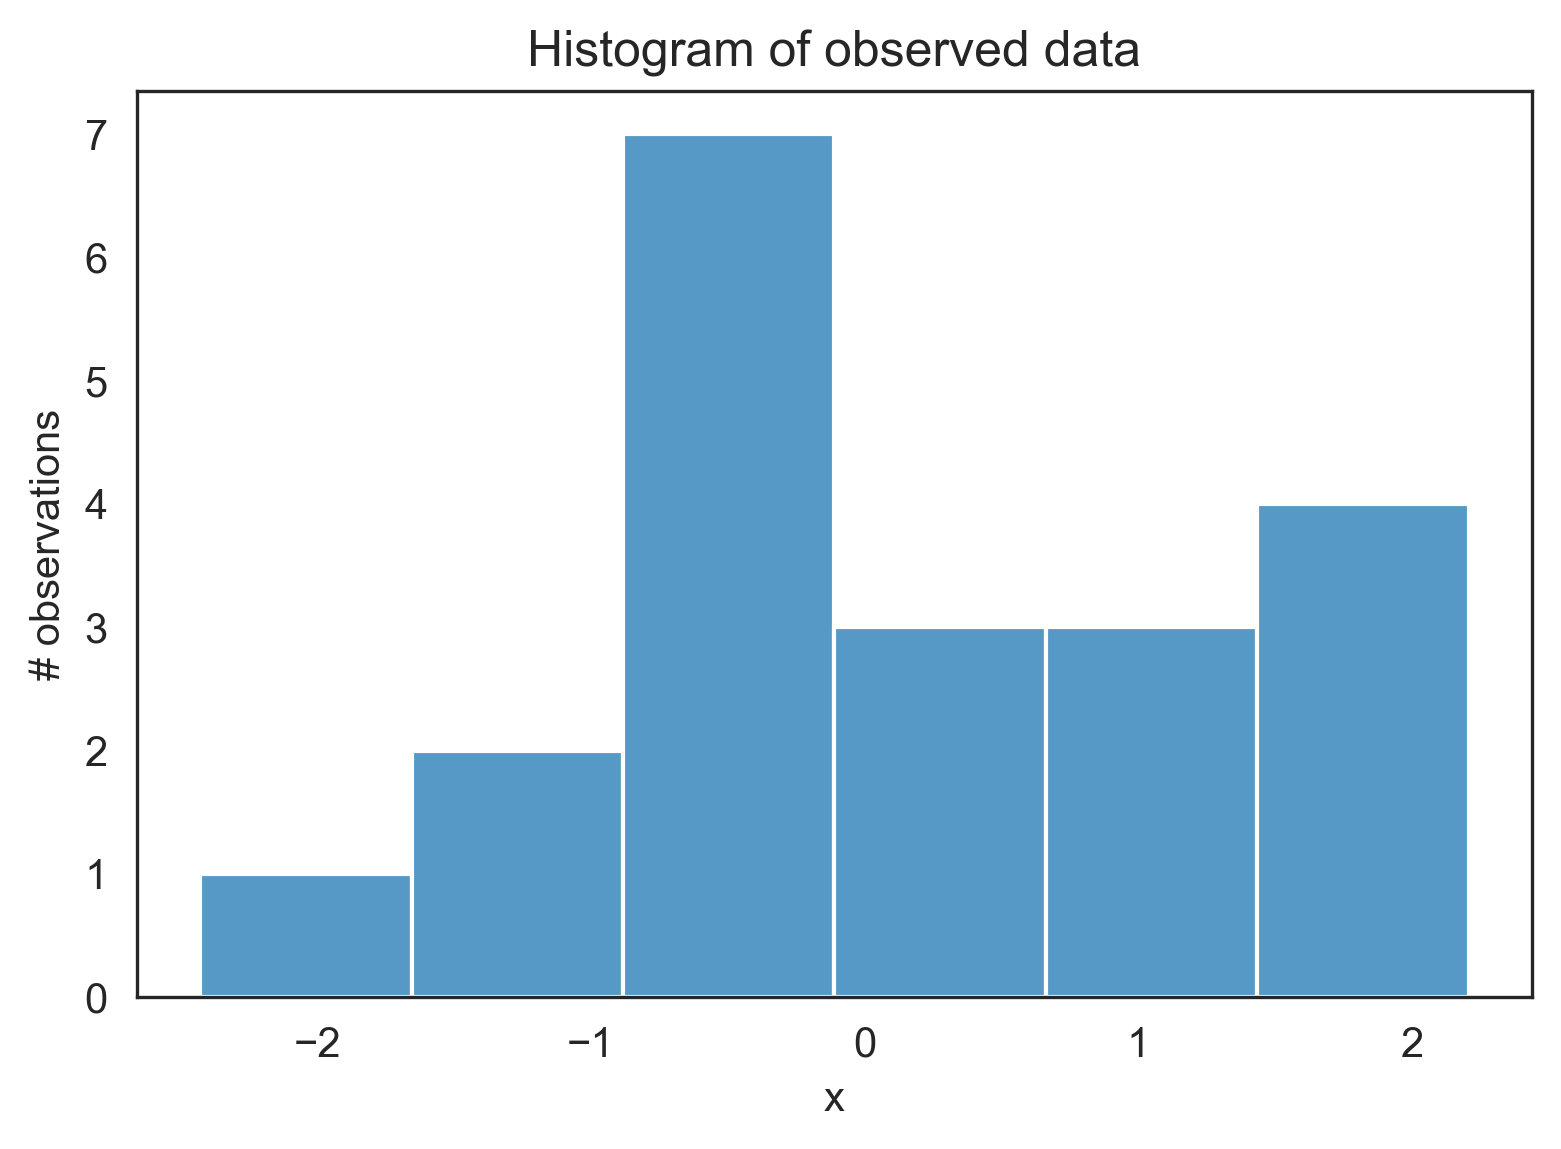

In [3]:
ax = plt.subplot()
sns.histplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

## Model definition
For simplicity, we have assumed 
$\sigma = 1$ is known and we infer the posterior for $\mu.$ For
each parameter we want to infer, we have to choose a prior. For
simplicity, we also take a normal distribution as the prior for
$\mu.$ Thus,  our model is

$$\mu \sim \mathcal{N}(0, 1), \qquad
x|\mu \sim \mathcal{N}(x; \mu, 1).$$

For this model, we actually can compute the
posterior analytically, since for a normal likelihood with
known standard deviation, the normal prior for `mu` is
conjugate and the posterior then has the same distribution as the prior, with suitably modified expectation and variance. 

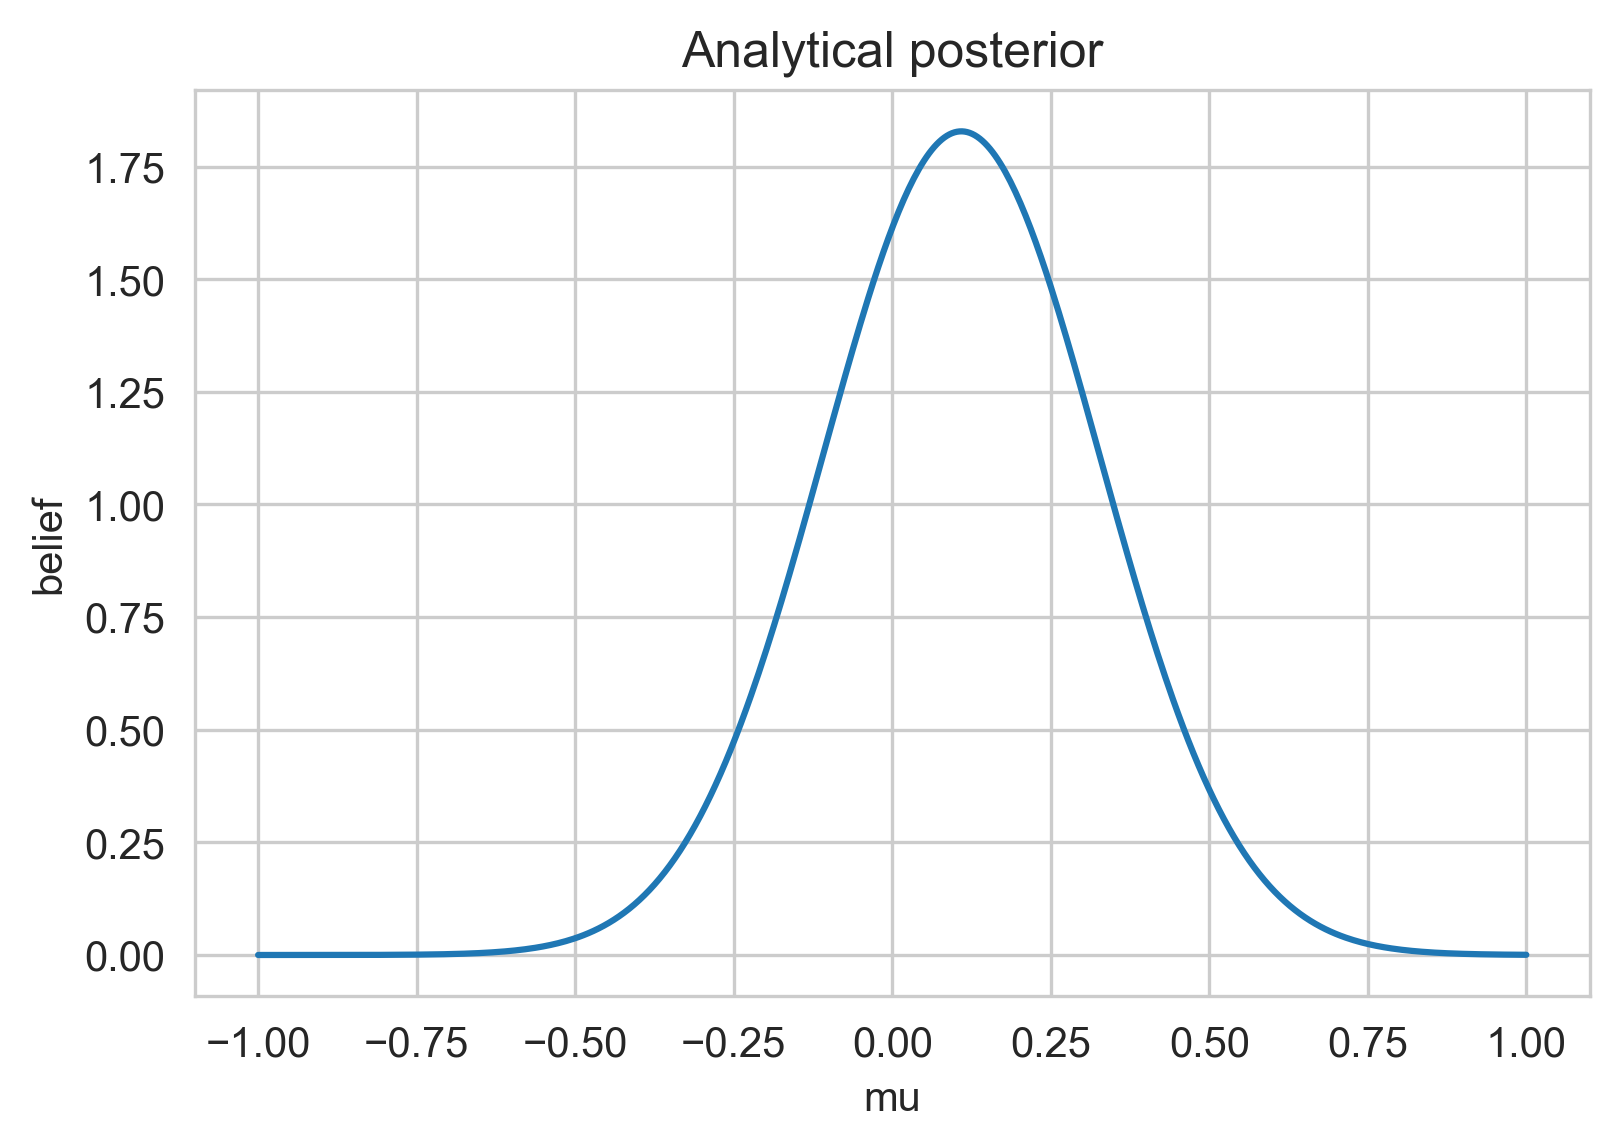

In [4]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

sns.set_style('whitegrid')
ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
#sns.despine()

This shows our quantity of interest, the probability of $\mu$'s values after having seen the data, taking our prior information into account. Now we assume, however, that our prior was not conjugate and we could not
solve this analytically, which is usually the case. In these cases, we naturally turn to MCMC sampling.

## Explanation of MCMC sampling with code

We demonstrate the MCMC sampling logic. At first, we need a starting parameter position that can be randomly chosen, but we  fix it arbitrarily to say

```python
mu_current = 0.5
```
Then, propose to move (jump) from that position somewhere else--this is
the Markov part. Different strategies are possible for the proposal. The Metropolis sampler is the simplest and just takes a sample from a normal distribution, having no relationship to the normal distribution we assumed for the model, centered around the current  `mu` value (i.e.`mu_current`)) with a certain standard deviation, known as the `proposal_width`, that will determine how far the proposal jumps. For this Brownian step, we use `scipy.stats.norm`.

```python
proposal = norm(mu_current, proposal_width).rvs()
```
Next, we evaluate whether the proposal is a good place to jump to or not. If the resulting normal distribution with the proposed `mu` explains the data better than the old `mu`, we definitely want to go there. What does "explains the data better" mean? We quantify fit by
computing the probability of the data, given the likelihood (normal)
with the proposed parameter values---proposed `mu`  and a fixed
`sigma = 1`. This can easily be computed by calculating the
probability for each data point using `scipy.stats.normal(mu, sigma).pdf(data)` and then multiplying the individual probabilities, i.e. computing the likelihood. Note that usually we would use log probabilities for this so that the product is converted into a sum.


```python
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

# Numerator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

```

Up until now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the `mu_proposal` has higher likelihood than `mu_current`. Eventually we will reach `mu = 0` (or close to it) from where no more moves will be possible. However, we want to compute a posterior so we will also have to sometimes accept moves into the other direction. The key trick is by dividing the two probabilities,

```python
p_accept = p_proposal / p_current
```

we get an acceptance probability. We can already see that if `p_proposal` is larger, that probability will be `> 1` and we will definitely accept. However, if `p_current` is larger, say twice as large, there will be a 50% chance of moving there. To compute this, we draw a  $\mathcal{U}[0,1]$ random value and compare it to the acceptance probability,

```python
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

```

This simple procedure, the veritable core of the Markov chain, gives us samples from the posterior.



### Putting it all together
Here is the complete function that performs the MCMC sampling. 

In [1]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

MCMC works by repeating this sampling procedure over a long time, then the samples generated are guaranteed by the theorems seen above, to come from the posterior distribution of our model. 

To visualize this, we can draw a large number of samples and plot them.

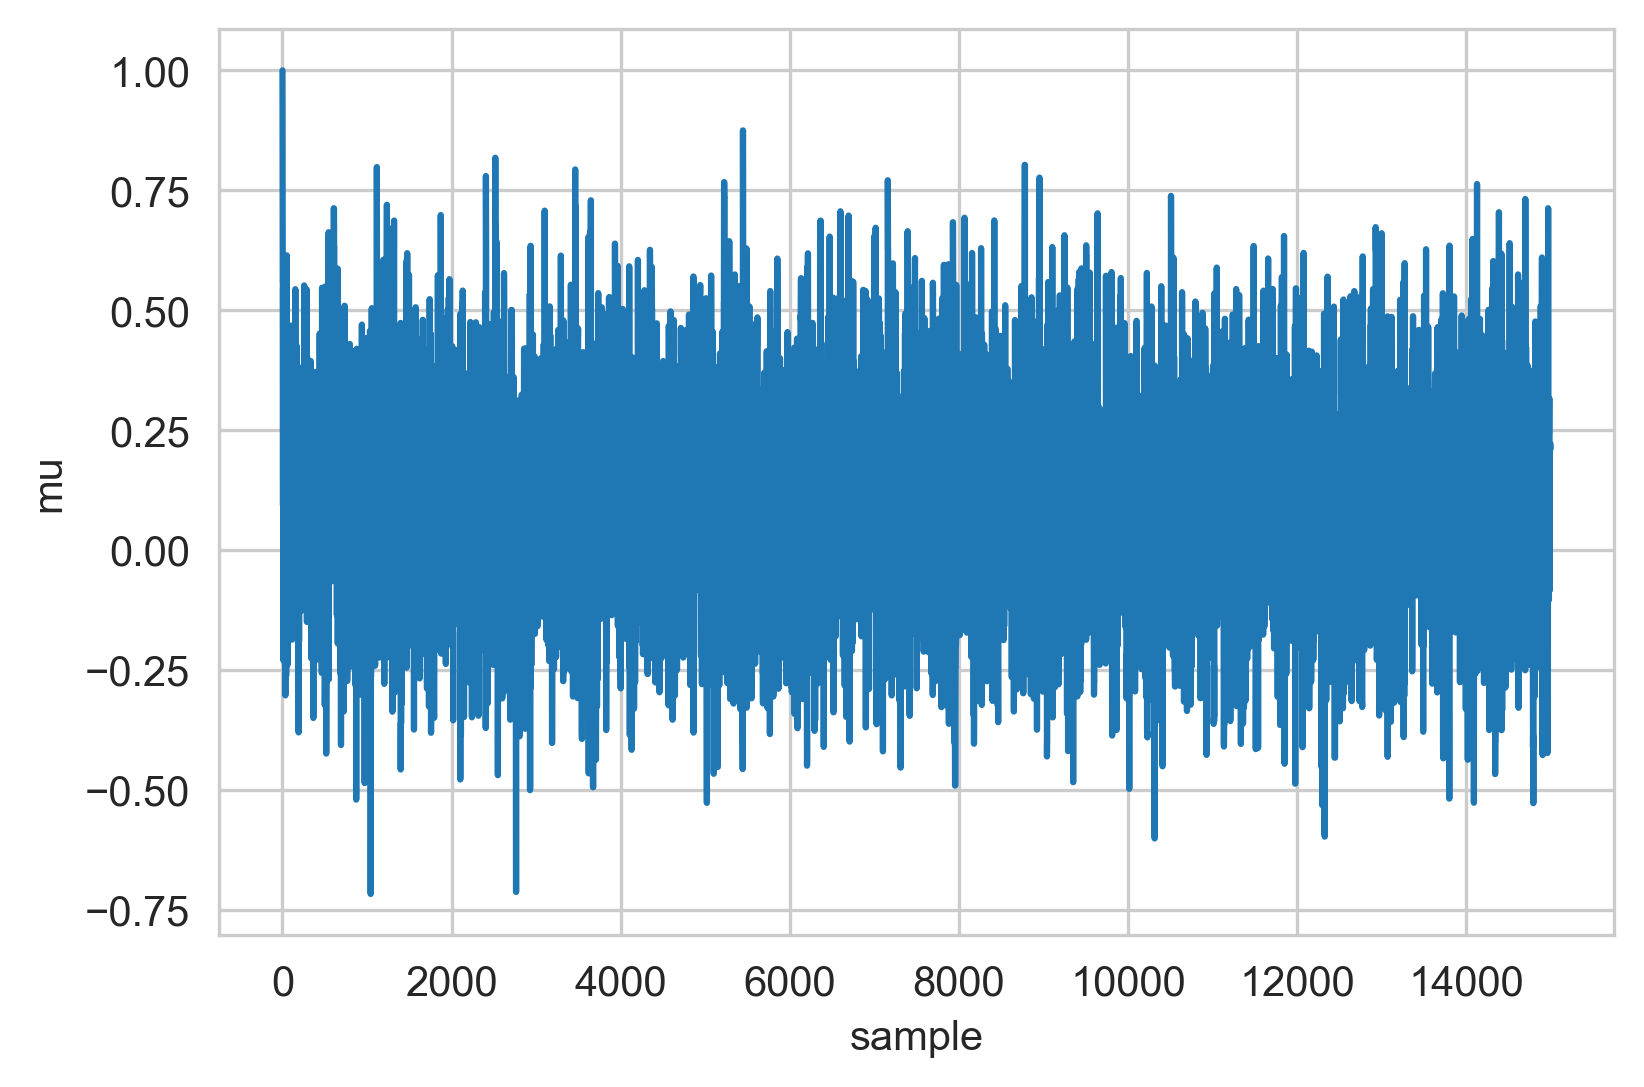

In [7]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

This plot is usually called the trace. To obtain  an approximation of the
posterior from it, we simply compute the histogram of this trace. It is important to keep in mind that although this looks similar to the data we sampled above to fit the model, the two are completely separate. The next plot represents our *belief*, in the Bayesian sense, in  `mu`. In this conjugate case it just happens to also be normal, but for a different model it could have a completely different shape than the likelihood or prior.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


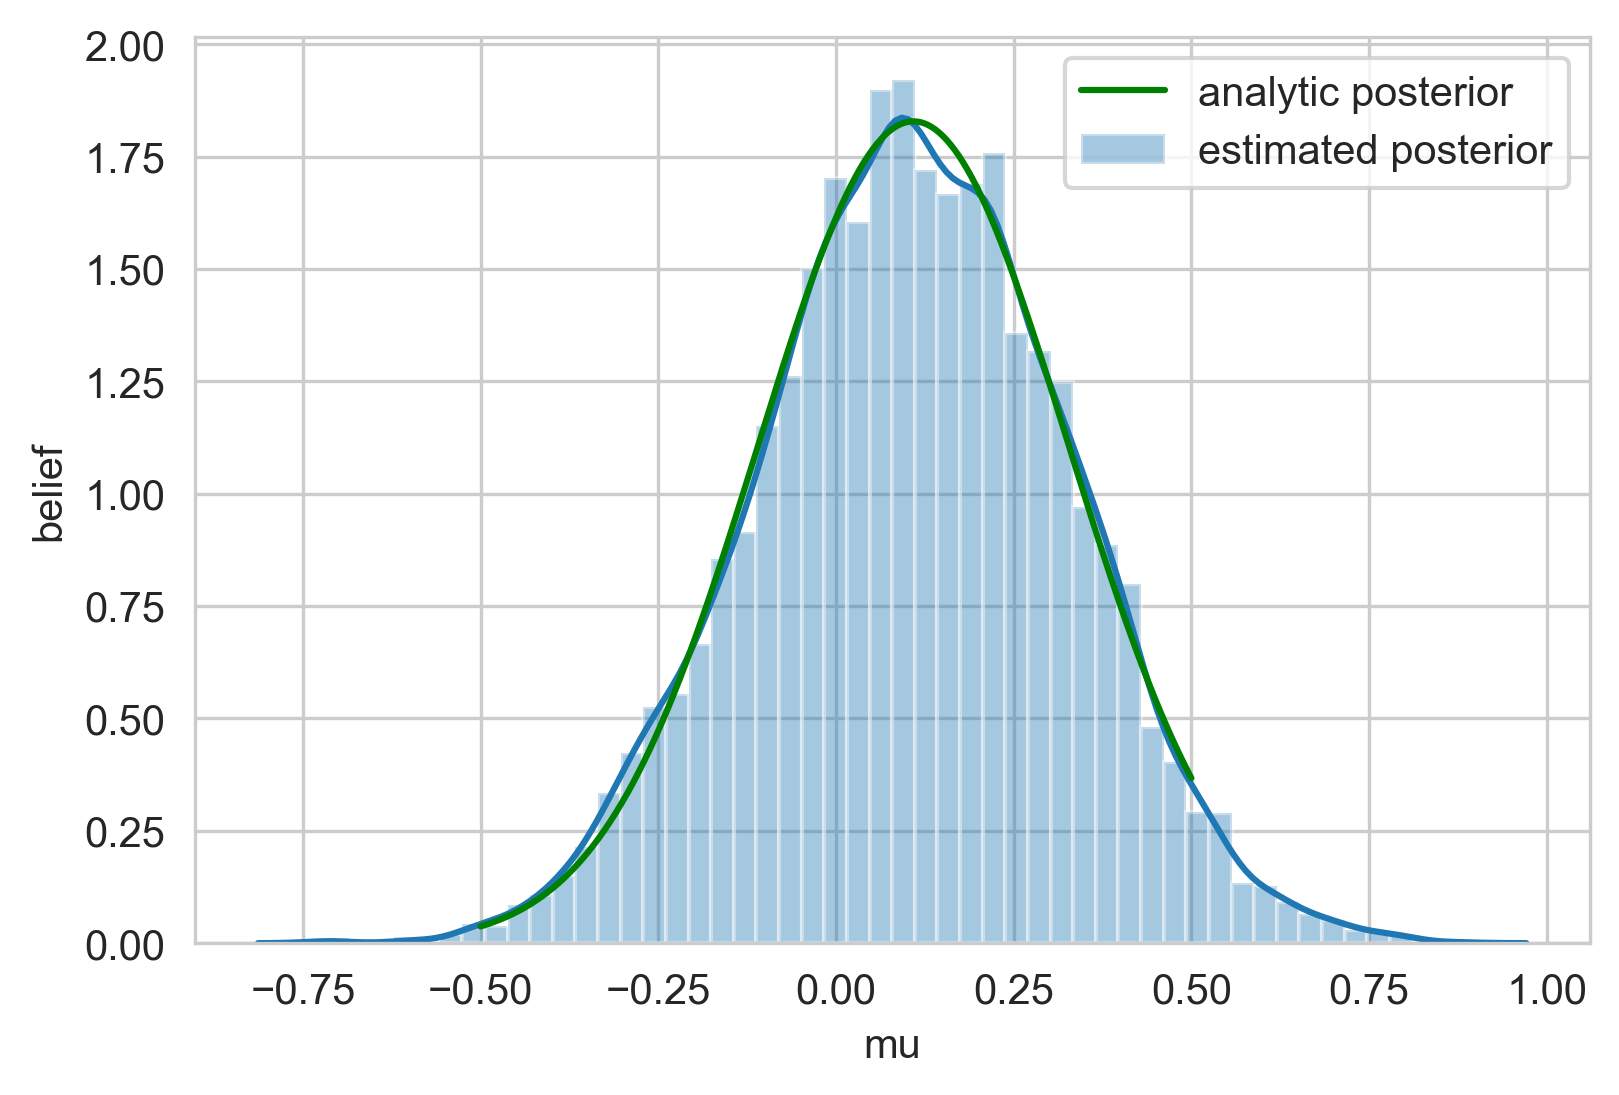

In [8]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500) # exclude burn-in samples (first 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();


### Alternative approach: grid sampling

When the dimension of the parameter vector is small, we can simply sample the range of possible values for $\mu$ and compute the posterior by multiplication. Finally we display the histogram. This will however not be tractable as soon as we have more than 4 or 5 parameters to estimate, due to the curse of dimensionality. 

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-1.0, 1.0)

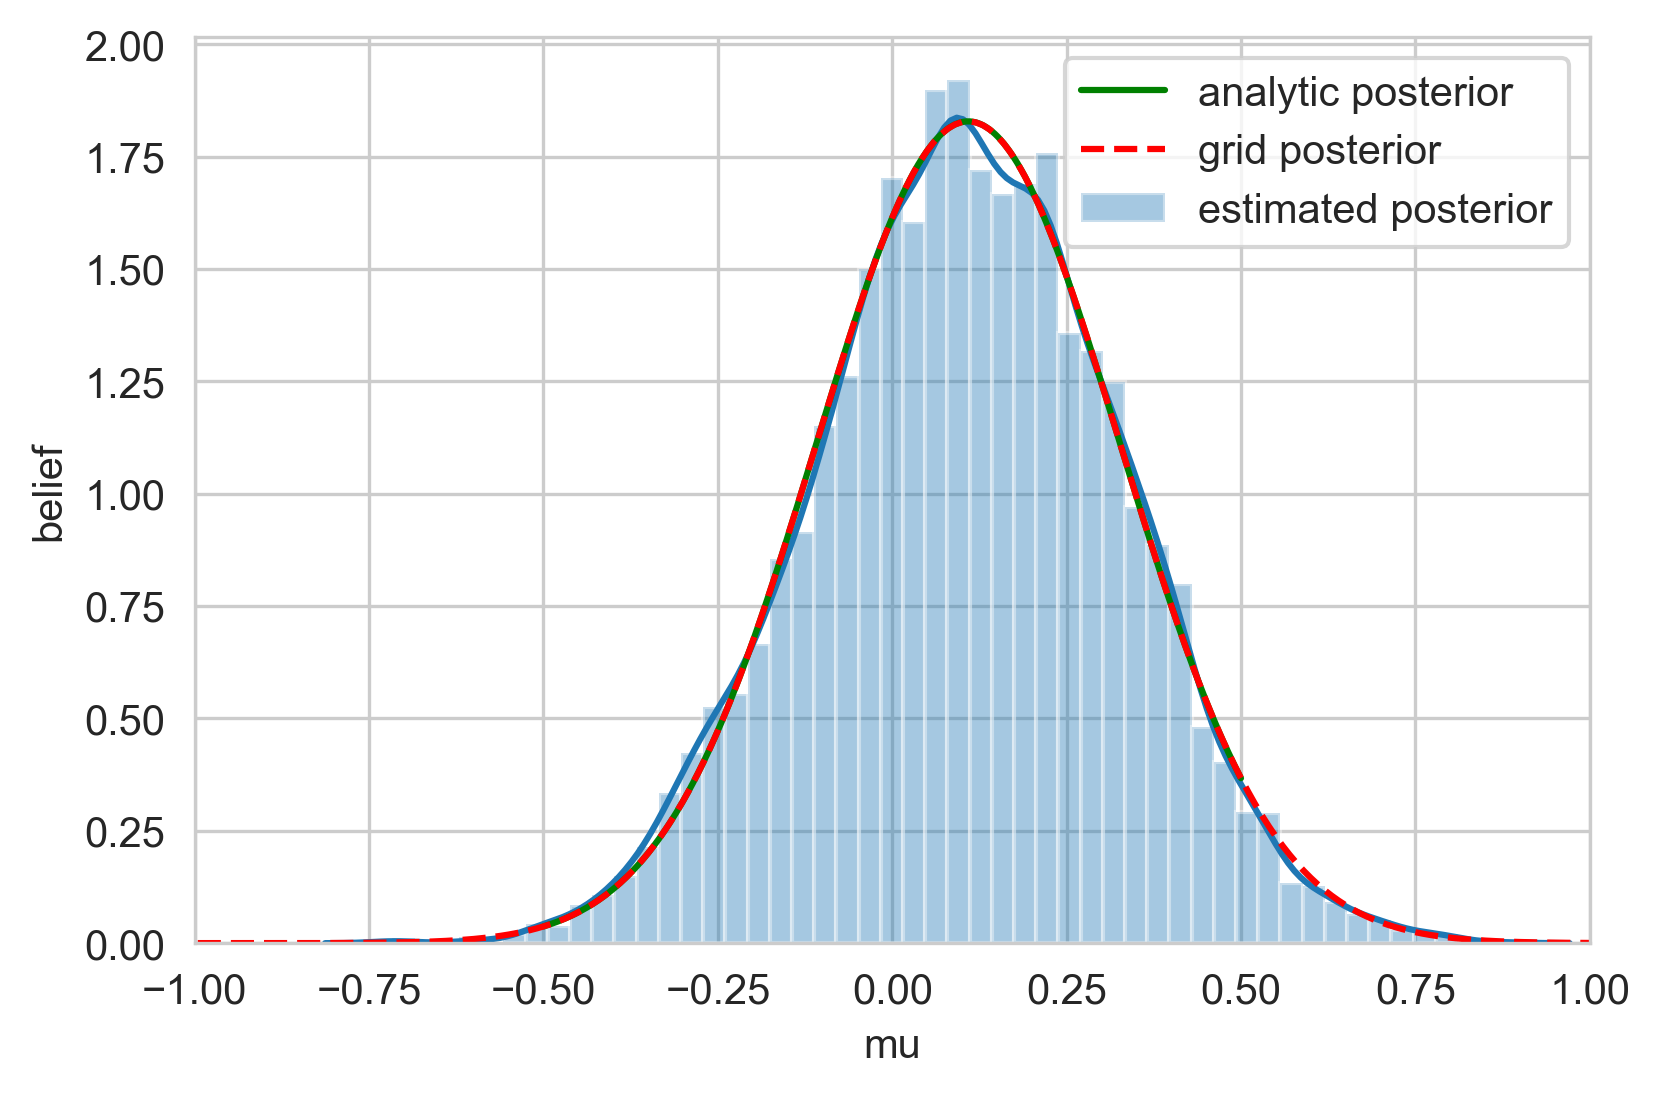

In [9]:
# Exhaustive grid sampling

mu_prior_mu=0
mu_prior_sd=1.

gr_posterior = list()

mu_is = np.linspace(-3, 3, 601)
for mu_i in mu_is:
    prior_i = norm(mu_prior_mu, mu_prior_sd).pdf(mu_i)
    likelihood_i = norm(mu_i, 1).pdf(data).prod()
    gr_posterior.append(likelihood_i * prior_i)

# Calculate normalizing constant:
gr_posterior_sum = sum(gr_posterior)/100. # divide by 100 since every bin in the prior histogram (prior_i) has the width of 0.01

# Final posterior is:
gr_posterior = gr_posterior / gr_posterior_sum
# Plot and compare
ax1 = plt.subplot()

sns.distplot(posterior[500:], ax=ax1, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax1.plot(x, post, color='g', label='analytic posterior')
x = np.linspace(-3, 3, 601)
ax1.plot(x, gr_posterior, color='r', linestyle='--', label='grid posterior')
_ = ax1.set(xlabel='mu', ylabel='belief');
ax1.legend();
plt.xlim([-1, 1])

We see that by following the above procedure, we get samples from the same distribution as the one derived analytically, as well as the distribution that was computed by MCMC.

## Proposal width

Above we set the proposal width to `0.5` which turned out to be a
reasonably good value. In general we do not want the width to be too narrow because the sampling will be inefficient as it takes a long time to
explore the whole parameter space and shows the typical random-walk
behavior. Let us compute the chain with a small width of $0.01.$

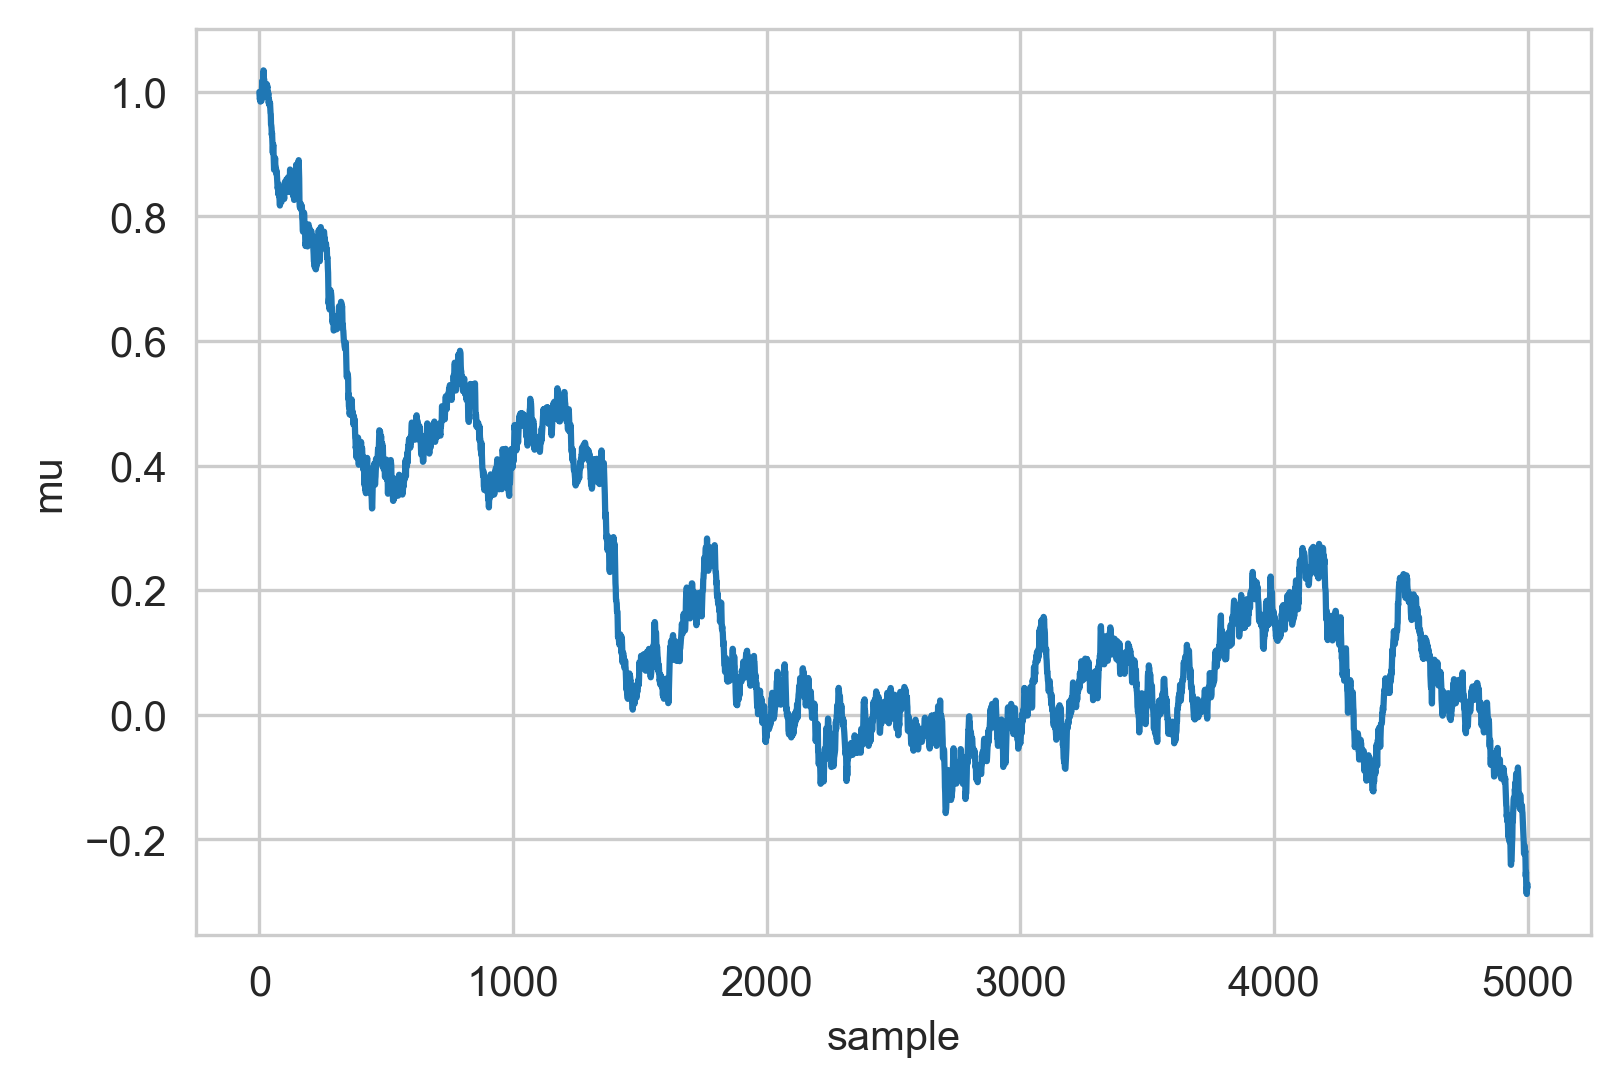

In [10]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

Now, we contrast with a larger width, $3,$ that should not be so large that we hardly ever accept a jump.

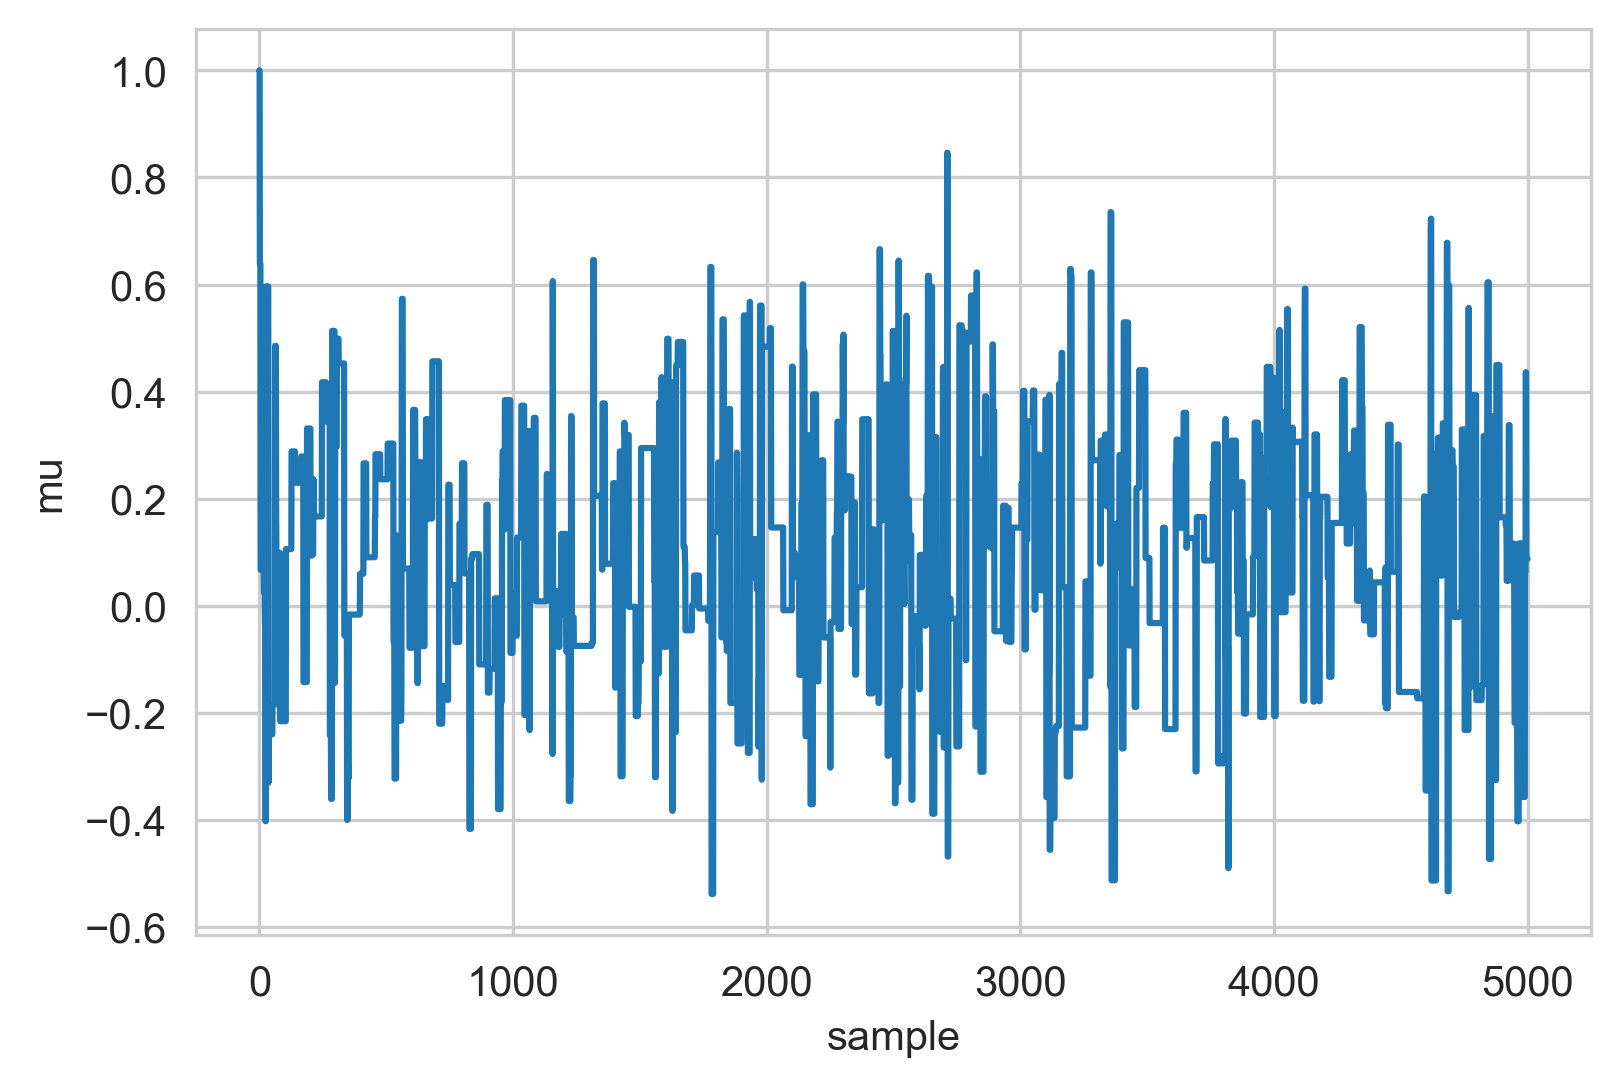

In [11]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

Note, however, that we are still sampling from our target posterior
distribution here, as guaranteed by the mathematical proof, just less
efficiently, as can be clearly seen in this comparison plot.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


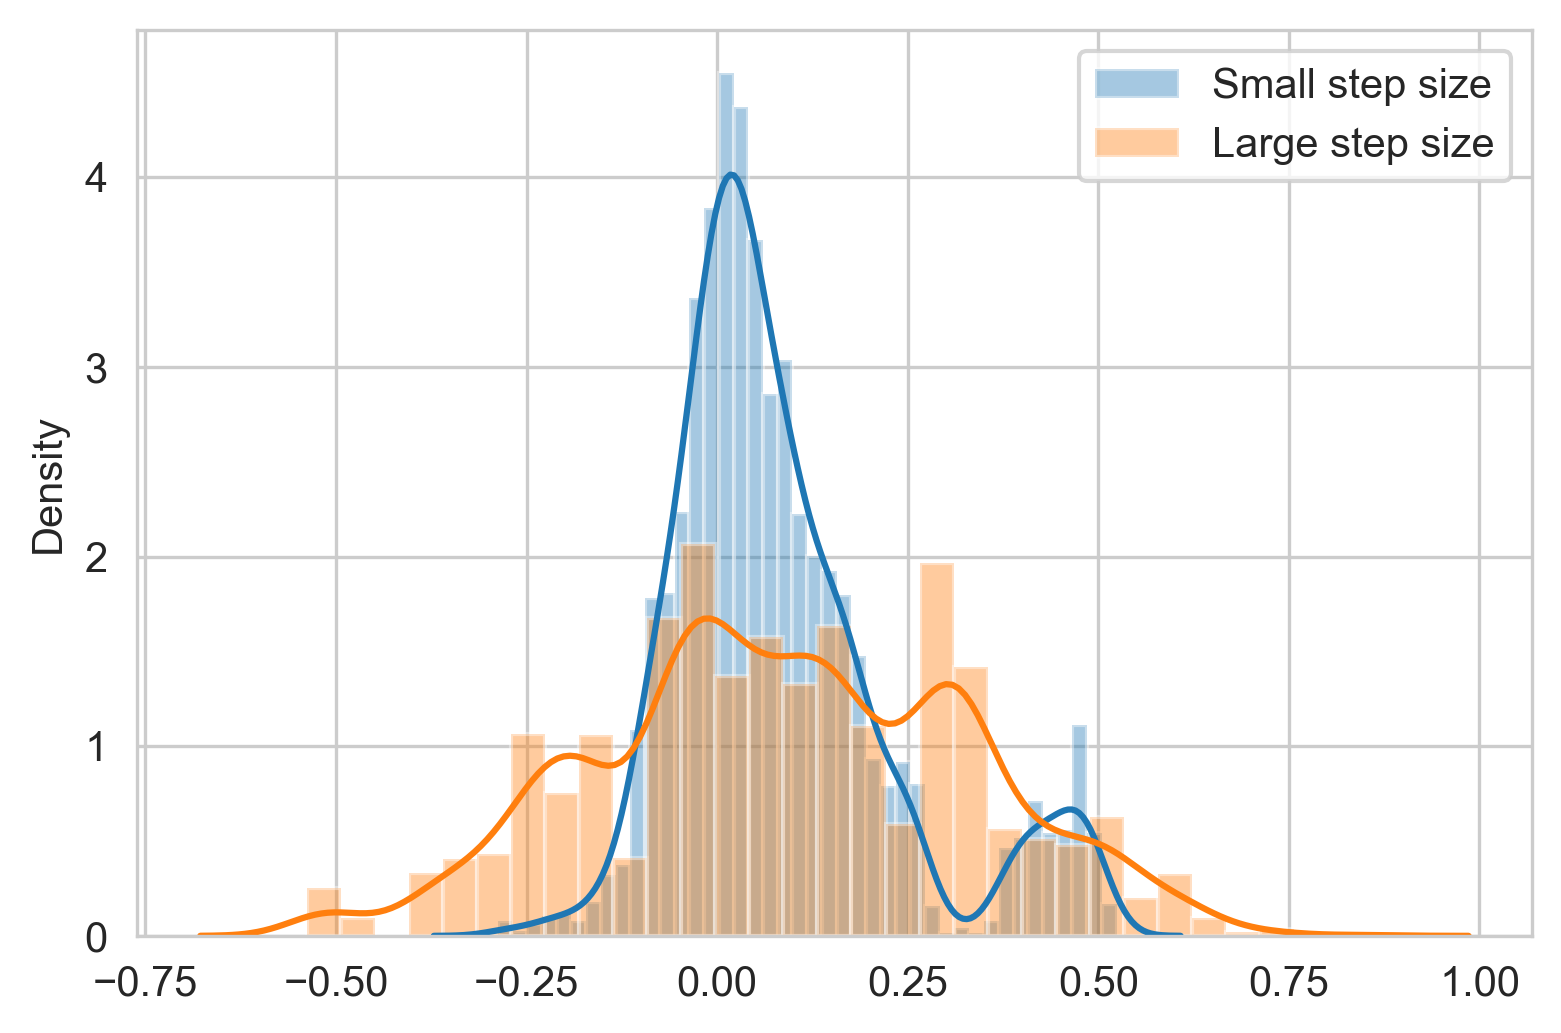

In [12]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

With more samples this will eventually look like the true posterior. The key is that we want our samples to be independent of each other, which cleary is not the case with a large proposal width. Thus, one common metric to evaluate the efficiency of our sampler is the autocorrelation -- i.e. how correlated a sample `i` is to sample `i-1`, `i-2`, etc:

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


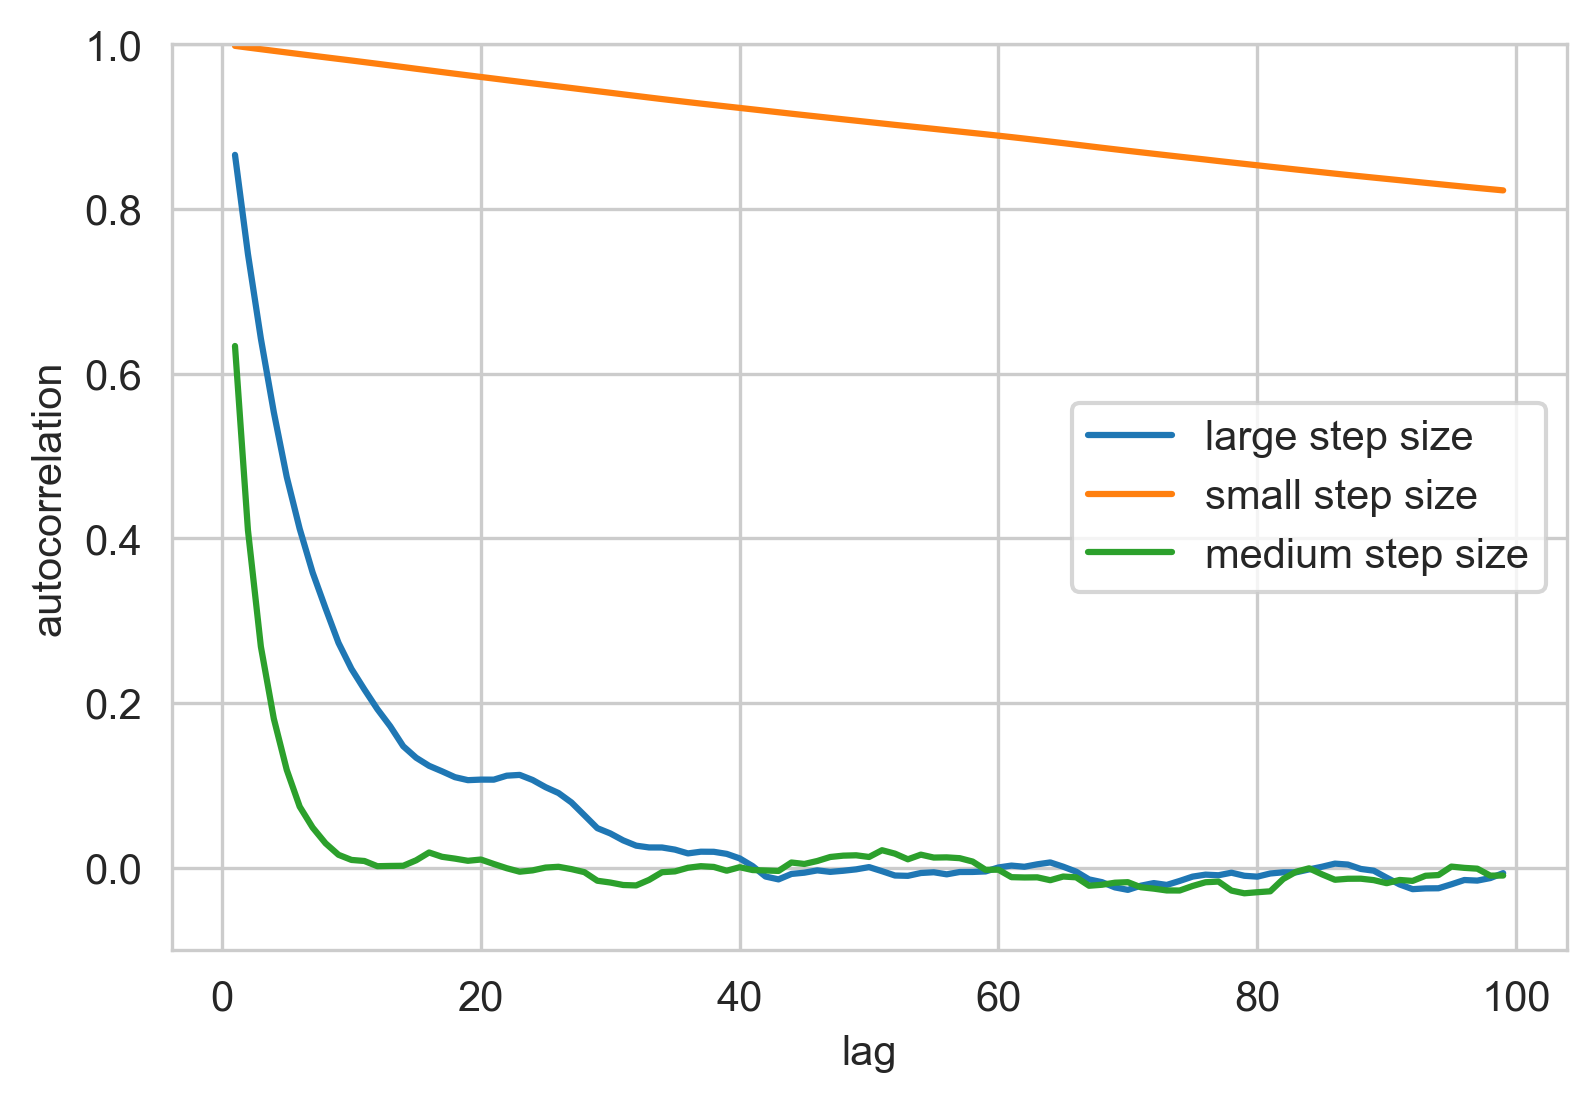

In [13]:
from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots()
ax.plot(lags, [autocorr(posterior_large, l) for l in lags], label='large step size')
ax.plot(lags, [autocorr(posterior_small, l) for l in lags], label='small step size')
ax.plot(lags, [autocorr(posterior, l) for l in lags], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

The medium step case, with proposal width of $0.5,$ produces the sharpest decrease in autocorrelation, which is a sign of independence of the successive steps. We would like to have a criterion for determining the good step width automatically. One common method is to keep adjusting the proposal width so that roughly 50% of the proposals are rejected.

## Extending to more complex models

Now we could also add a `sigma` parameter for the standard-deviation and follow the same procedure for inferring this second parameter. In this case, we would be generating proposals for both `mu` and `sigma`, but the algorithm logic would be nearly identical. Or, we could have data from a very different distribution, like a Binomial, and still use the same algorithm and get the correct posterior. Here we coiuld definitely benefit from  probabilistic programming, where we just define the model we want and let MCMC take care of the inference. 

For example, the below model can be written in `PyMC3` quite easily. Below we also use the Metropolis sampler (which automatically tunes the proposal width) and see that we get identical results.

```python
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)
    
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
sns.distplot(posterior[500:], label='Hand-written sampler');
plt.legend();
```
